Лабораторна 4

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

Завантажуємо дані тренувальних, валідаційних і тестувальних вибірок.
Маштабуємо всі зображння до 224*224 пікселів.

In [10]:
train_data = ImageDataGenerator(rescale=1./255).flow_from_directory('source/Cats_and_Dogs/train', target_size=(224, 224), batch_size=32, class_mode='binary') 

valid_data = ImageDataGenerator(rescale=1./255).flow_from_directory('source/Cats_and_Dogs/val', target_size=(224, 224), batch_size=32, class_mode='binary')

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory('source/Cats_and_Dogs/test', target_size=(224, 224), batch_size=32, class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


Перша модель це звичайна повнозв'язна мережа з 3 шарів

In [5]:
dence_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

dence_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = dence_model.fit(train_data,
          epochs=5,
          validation_data=valid_data)

test_loss, test_acc = dence_model.evaluate(test_data)
print('Test accuracy:', test_acc)


Epoch 1/5


625/625 [==============================] - 279s 443ms/step - loss: 2.3275 - accuracy: 0.5354 - val_loss: 1.4347 - val_accuracy: 0.5016
Epoch 2/5
625/625 [==============================] - 178s 285ms/step - loss: 0.8682 - accuracy: 0.5737 - val_loss: 0.7595 - val_accuracy: 0.5554
Epoch 3/5
625/625 [==============================] - 173s 277ms/step - loss: 0.7044 - accuracy: 0.5861 - val_loss: 0.6903 - val_accuracy: 0.5671
Epoch 4/5
625/625 [==============================] - 182s 291ms/step - loss: 0.6594 - accuracy: 0.6086 - val_loss: 0.6641 - val_accuracy: 0.5916
Epoch 5/5
79/79 [==============================] - 16s 204ms/step - loss: 0.6700 - accuracy: 0.5912
Test accuracy: 0.5911999940872192


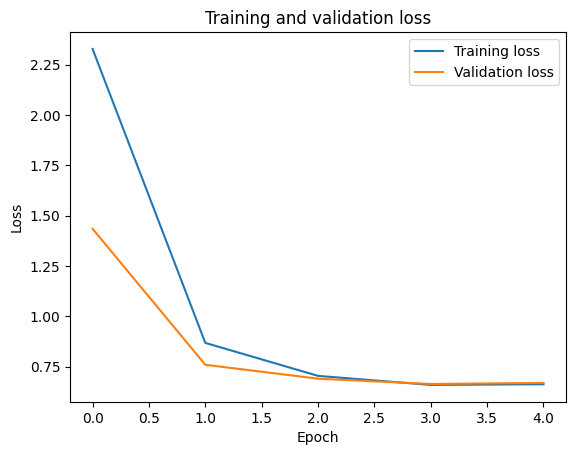

In [7]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Як бачим модель вийшла на плато з точністю трохи вище за випадкове вгадування, що не є задовільним.

Тепер легка згорткова мережа з двох блоків згортки + пулінгу і двома повнозв'язними шарами

In [11]:
conv_model = Sequential([
    Conv2D(64, (5, 5), activation='relu', input_shape=(224, 224, 3), padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

conv_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = conv_model.fit(train_data,
          epochs=5,
          validation_data=valid_data)

test_loss, test_acc = conv_model.evaluate(test_data)
print('Test accuracy:', test_acc)

Epoch 1/5
625/625 [==============================] - 765s 1s/step - loss: 0.6678 - accuracy: 0.5911 - val_loss: 0.6203 - val_accuracy: 0.6426
Epoch 2/5
625/625 [==============================] - 978s 2s/step - loss: 0.5960 - accuracy: 0.6822 - val_loss: 0.6061 - val_accuracy: 0.6719
Epoch 3/5
625/625 [==============================] - 874s 1s/step - loss: 0.5318 - accuracy: 0.7309 - val_loss: 0.5941 - val_accuracy: 0.7040
Epoch 4/5
625/625 [==============================] - 740s 1s/step - loss: 0.4240 - accuracy: 0.7993 - val_loss: 0.6218 - val_accuracy: 0.7040
Epoch 5/5
79/79 [==============================] - 22s 275ms/step - loss: 0.8000 - accuracy: 0.7068
Test accuracy: 0.7067999839782715


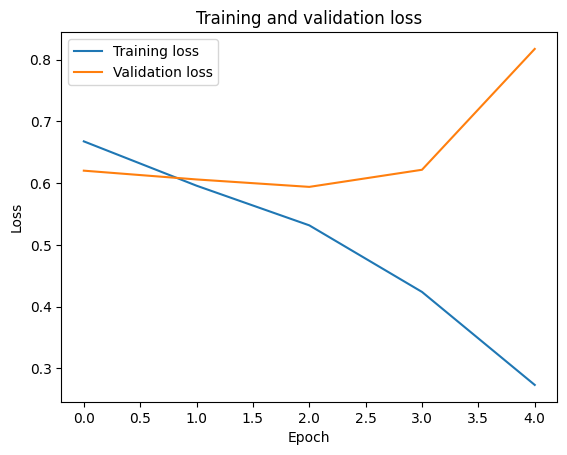

In [12]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Для даної моделі бачимо факт перенавчання після друої епохи, що видно зі зростання похибки при валідації, що пов'язано зі збільшення дисперсії моделі.

Тепер спробуємо зафайнтюнити дві великі натреновані моделі на нашиому датасеті. Починем з VGG-19.

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    if 'conv' in layer.name:
        layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
    history = model.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/5
625/625 [==============================] - 1131s 2s/step - loss: 0.4438 - accuracy: 0.7890 - val_loss: 0.4092 - val_accuracy: 0.8112
Epoch 2/5
625/625 [==============================] - 1165s 2s/step - loss: 0.3847 - accuracy: 0.8213 - val_loss: 0.4230 - val_accuracy: 0.8036
Epoch 3/5
625/625 [==============================] - 1142s 2s/step - loss: 0.3695 - accuracy: 0.8304 - val_loss: 0.4088 - val_accuracy: 0.8116
Epoch 4/5
625/625 [==============================] - 1179s 2s/step - loss: 0.3444 - accuracy: 0.8438 - val_loss: 0.3847 - val_accuracy: 0.8197
Epoch 5/5
79/79 [==============================] - 116s 1s/step - loss: 0.4005 - accuracy: 0.8128
Test accuracy: 0.8127999901771545


Результати значно краще за повнозв'язну модель та краще за просту згорткову мережу. Тепер ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    if 'conv' in layer.name:
        layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
    history = model.fit(train_data,
                        epochs=5,
                        validation_data=valid_data)

test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

Found 20000 images belonging to 2 classes.
Found 2490 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Epoch 1/5
625/625 [==============================] - 381s 598ms/step - loss: 0.6523 - accuracy: 0.6403 - val_loss: 0.6255 - val_accuracy: 0.6321
Epoch 2/5
625/625 [==============================] - 387s 620ms/step - loss: 0.6089 - accuracy: 0.6668 - val_loss: 0.6803 - val_accuracy: 0.5892
Epoch 3/5
625/625 [==============================] - 395s 633ms/step - loss: 0.5791 - accuracy: 0.6945 - val_loss: 0.5738 - val_accuracy: 0.7072
Epoch 4/5
625/625 [==============================] - 403s 645ms/step - loss: 0.5627 - accuracy: 0.7063 - val_loss: 0.5654 - val_accuracy: 0.7137
Epoch 5/5
79/79 [==============================] - 40s 507ms/step - loss: 0.6186 - accuracy: 0.6588
Test accuracy: 0.6588000059127808


Тут результати гірші за vgg-19. Це можна пов'язати із типом пулінгу всередині моделі, та і в цілому принципом їх побудови.